# 目标检测中的坐标回归

全卷积网络，预测车牌16个关键。
和大多数目标检测网络中的BBox定位一样，目标检测中是要预测BBox的x，y，w和h，其实思想是一样的。

In [1]:
import os
import numpy as np
from skimage import io,transform
import matplotlib.pyplot as plt
import torch
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

## 数据集可视化

Image name: 20171016121026584(粤B33533D-绿)sp.jpg
Landmarks shape: (16, 2)
First 4 Landmarks: [[ 24   1]
 [ 64   7]
 [104  15]
 [142  22]]


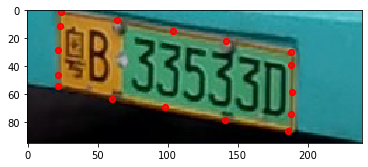

In [2]:
with open("PlateKeyPoint/train.txt","r") as f:
    lines = f.readlines()
    
img_name, landmarks = lines[0].strip().split(" ",1)
# print(landmarks)
landmarks = [int(l) for l in landmarks.split(" ")]
 
# print(landmarks)
landmarks = np.array(landmarks)
# print(landmarks)
landmarks = landmarks.reshape(-1,2)
print('Image name: {}'.format(img_name))
# print(landmarks)
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))
 
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='.', c='r',linewidths = 5)
 
plt.figure()
show_landmarks(io.imread(os.path.join('PlateKeyPoint/train/', img_name)),
               landmarks)
plt.show()

## 重写数据加载

In [3]:
def read_label(label_file):
    with open(label_file,"r") as f:
        lines = f.readlines()
    newlines = [line.strip().split(" ",1) for line in lines]
    return newlines
    
class PlateKeyPointDataset(Dataset):
    def __init__(self, label_file, root_dir, transform = None):
        self.keypoint = read_label(label_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.keypoint)
    
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,self.keypoint[idx][0])
        image = io.imread(img_name)
        kp = self.keypoint[idx][1]
        kp = [int(p) for p in kp.split(" ")]
        kp = np.array(kp)
        kp = kp.astype("float").reshape(-1,2)
        sample = image,kp
        if self.transform:
            sample = self.transform(sample)            
        return sample      
        


## 实现简单的预处理转换

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, kp = sample[0], sample[1]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        kp = kp * [new_w / w, new_h / h]
#         kp = kp.flatten()

        return img, kp

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors.
        numpy数组到tensor的变化，另外还有维度的变化。
    """
 
    def __call__(self, sample):
        image, kp = sample[0], sample[1]
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        label = torch.from_numpy(kp)
        return image.type(torch.FloatTensor),label.type(torch.FloatTensor),

In [6]:
platekptrain = PlateKeyPointDataset(label_file="./PlateKeyPoint/train.txt",root_dir="./PlateKeyPoint/train",transform=transforms.Compose([Rescale((64,128)),ToTensor()]))
platekpval = PlateKeyPointDataset(label_file="./PlateKeyPoint/val.txt",root_dir="./PlateKeyPoint/val",transform=transforms.Compose([Rescale((64,128)),ToTensor()]))

In [56]:
print("训练集大小：%d"%len(platekptrain))
print("验证集大小：%d"%len(platekpval))

训练集大小：693
验证集大小：41


In [8]:
# platekp2 = PlateKeyPointDataset(label_file="./PlateKeyPoint/train.txt",root_dir="./PlateKeyPoint/train")

In [9]:
# fig = plt.figure()
# for i in range(len(platekp2)):
#     sample = platekp[i]
#     print(i, sample[0].shape, sample[].shape )
#     ax = plt.subplot(1,4,i+1)
#     plt.tight_layout()
#     ax.set_title('keypoint #{}'.format(i))
#     ax.axis('off')
# #     print(*sample.values())
#     show_landmarks(*sample.values())
#     if i == 3:
#         plt.show()
#         break


lr衰减和warm up，使用xavier初始化CNN权重

In [10]:
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = initial_lr * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def warmup_learning_rate(optimizer,iteration):
    lr_ini = 0.000001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_ini+(initial_lr - lr_ini)*iteration/100

def xavier(param):
    init.xavier_uniform_(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

## DataLoader

In [11]:
trainloader = DataLoader(platekptrain, batch_size=32, shuffle=True, num_workers=4)
valloader = DataLoader(platekpval, batch_size=32, shuffle=False, num_workers=4)

## 模型搭建

网络结构搭建，这这里仿照VGG结构，去掉全连接层，并在最后加入1x1卷积用于关键点的回归
![](https://t9.baidu.com/it/u=463051614,2727077879&fm=193)

In [12]:
class VGGRegNet(nn.Module):
    def __init__(self):
        super(VGGRegNet, self).__init__()
        self.conv1_0 = nn.Conv2d(3,16,3,padding=1)
        self.conv1_1 = nn.Conv2d(16,16,3,padding=1)
        self.conv2_0 = nn.Conv2d(16,32,3,padding=1)
        self.conv2_1 = nn.Conv2d(32,32,3,padding=1)
        self.conv3_0 = nn.Conv2d(32,64,3,padding=1)
        self.conv3_1 = nn.Conv2d(64,64,3,padding=1)
        self.conv4_0 = nn.Conv2d(64,128,3,padding=1)
        self.conv4_1 = nn.Conv2d(128,128,3,padding=1)
        self.conv5_0 = nn.Conv2d(128,256,3,padding=1)
        self.conv5_1 = nn.Conv2d(256,256,3,padding=1)
        self.conv6_0 = nn.Conv2d(256,512,3,padding=1)
        self.conv6_1 = nn.Conv2d(512,512,3,padding=1)
        self.loc = nn.Conv2d(512,16,1)
                     
    def forward(self, x):                             #64x128x3
        x = F.relu(self.conv1_0(x))
        x = F.max_pool2d(F.relu(self.conv1_1(x)),2)     #32x64x16
        x = F.relu(self.conv2_0(x))
        x = F.max_pool2d(F.relu(self.conv2_1(x)),2)     #16x32x32
        x = F.relu(self.conv3_0(x))
        x = F.max_pool2d(F.relu(self.conv3_1(x)),2)     #8x16x64
        x = F.relu(self.conv4_0(x))
        x = F.max_pool2d(F.relu(self.conv4_1(x)),2)     #4x8x128
        x = F.relu(self.conv5_0(x))
        x = F.max_pool2d(F.relu(self.conv5_1(x)),2)     #2x4x256
        x = F.relu(self.conv6_0(x))
        x = F.max_pool2d(F.relu(self.conv6_1(x)),2)     #1x2x512
        x = self.loc(x)                                 #1*2*16
#         x = x.view()
        return x       
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for i in size:
            num_features *= i
        return num_features

In [13]:
net= VGGRegNet()
net.apply(weights_init)
print(net)

VGGRegNet(
  (conv1_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc): Conv2d(512, 16, kernel

In [14]:
criterion = nn.SmoothL1Loss()
initial_lr = 0.001
optimizer = optim.AdamW(net.parameters(), lr = initial_lr)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


VGGRegNet(
  (conv1_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc): Conv2d(512, 16, kernel

## 网络训练

In [16]:
lr_decay = [1000,1600]
step_index = 0
tlall = []
vlall = []
for iteration in range(2000):
    running_loss= 0
    val_loss = 0
    start = time.time()
    batch_iterator = iter(trainloader)
    images, labels = next(batch_iterator)
#     print(images)
    images = images.to(device)
    labels = labels.to(device)
    val_iter = iter(valloader)
    valimg,vallabels = next(val_iter)
    valimg = valimg.to(device)
    vallabels = vallabels.to(device)

    optimizer.zero_grad()
    outputs= net(images)
#     print(outputs.size())
#     print(labels.size())
    outputs = outputs.squeeze(2)
#     print(outputs.size())
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
    val_out = net(valimg)
    val_out = val_out.squeeze(2)
    valloss = criterion(val_out,vallabels)
    val_loss += valloss.item()
    
    
    if iteration <=100:
        warmup_learning_rate(optimizer,iteration)
    if iteration in lr_decay:
        step_index += 1
        adjust_learning_rate(optimizer, 0.1, step_index)
    for param in optimizer.param_groups:
        if 'lr' in param.keys():  
            if iteration % 10 == 9:
                tlall.append(running_loss / 10)
                vlall.append(val_loss / 10)
                print("Iteration %d  || LR %f || TrainLoss: %.4f || ValLoss: %.4f || Time: %f"%(iteration+1,param['lr'],running_loss / 10,val_loss / 10,time.time()-start))
    running_loss = 0
            
print("Finish Training...")
            

Iteration 10  || LR 0.000091 || TrainLoss: 4.3198 || ValLoss: 4.2083 || Time: 0.407374
Iteration 20  || LR 0.000191 || TrainLoss: 2.6081 || ValLoss: 2.4505 || Time: 0.417677
Iteration 30  || LR 0.000291 || TrainLoss: 1.8270 || ValLoss: 1.7621 || Time: 0.407475
Iteration 40  || LR 0.000391 || TrainLoss: 1.2916 || ValLoss: 1.0827 || Time: 0.416326
Iteration 50  || LR 0.000491 || TrainLoss: 0.8419 || ValLoss: 0.9368 || Time: 0.405837
Iteration 60  || LR 0.000590 || TrainLoss: 0.5097 || ValLoss: 0.6325 || Time: 0.406980
Iteration 70  || LR 0.000690 || TrainLoss: 0.6444 || ValLoss: 0.6766 || Time: 0.439231
Iteration 80  || LR 0.000790 || TrainLoss: 0.5835 || ValLoss: 0.7020 || Time: 0.436677
Iteration 90  || LR 0.000890 || TrainLoss: 0.7994 || ValLoss: 1.1169 || Time: 0.418029
Iteration 100  || LR 0.000990 || TrainLoss: 1.6877 || ValLoss: 0.7214 || Time: 0.438395
Iteration 110  || LR 0.001000 || TrainLoss: 0.5955 || ValLoss: 1.0032 || Time: 0.412695
Iteration 120  || LR 0.001000 || TrainLos

Iteration 950  || LR 0.001000 || TrainLoss: 0.1258 || ValLoss: 0.1874 || Time: 0.405660
Iteration 960  || LR 0.001000 || TrainLoss: 0.0820 || ValLoss: 0.1757 || Time: 0.428074
Iteration 970  || LR 0.001000 || TrainLoss: 0.2705 || ValLoss: 0.1807 || Time: 0.415206
Iteration 980  || LR 0.001000 || TrainLoss: 0.0972 || ValLoss: 0.1970 || Time: 0.414114
Iteration 990  || LR 0.001000 || TrainLoss: 0.0877 || ValLoss: 0.1436 || Time: 0.419866
Iteration 1000  || LR 0.001000 || TrainLoss: 0.1157 || ValLoss: 0.2091 || Time: 0.424750
Iteration 1010  || LR 0.000100 || TrainLoss: 0.0943 || ValLoss: 0.0856 || Time: 0.410094
Iteration 1020  || LR 0.000100 || TrainLoss: 0.0790 || ValLoss: 0.0983 || Time: 0.434888
Iteration 1030  || LR 0.000100 || TrainLoss: 0.0573 || ValLoss: 0.0835 || Time: 0.442300
Iteration 1040  || LR 0.000100 || TrainLoss: 0.0642 || ValLoss: 0.0717 || Time: 0.417977
Iteration 1050  || LR 0.000100 || TrainLoss: 0.0561 || ValLoss: 0.0724 || Time: 0.417742
Iteration 1060  || LR 0.00

Iteration 1880  || LR 0.000010 || TrainLoss: 0.0467 || ValLoss: 0.0615 || Time: 0.436267
Iteration 1890  || LR 0.000010 || TrainLoss: 0.0426 || ValLoss: 0.0618 || Time: 0.411060
Iteration 1900  || LR 0.000010 || TrainLoss: 0.0479 || ValLoss: 0.0618 || Time: 0.417695
Iteration 1910  || LR 0.000010 || TrainLoss: 0.0492 || ValLoss: 0.0615 || Time: 0.417094
Iteration 1920  || LR 0.000010 || TrainLoss: 0.0436 || ValLoss: 0.0615 || Time: 0.419155
Iteration 1930  || LR 0.000010 || TrainLoss: 0.0412 || ValLoss: 0.0618 || Time: 0.404781
Iteration 1940  || LR 0.000010 || TrainLoss: 0.0399 || ValLoss: 0.0615 || Time: 0.448470
Iteration 1950  || LR 0.000010 || TrainLoss: 0.0361 || ValLoss: 0.0614 || Time: 0.398841
Iteration 1960  || LR 0.000010 || TrainLoss: 0.0365 || ValLoss: 0.0609 || Time: 0.435040
Iteration 1970  || LR 0.000010 || TrainLoss: 0.0464 || ValLoss: 0.0617 || Time: 0.427393
Iteration 1980  || LR 0.000010 || TrainLoss: 0.0550 || ValLoss: 0.0628 || Time: 0.427492
Iteration 1990  || LR

In [17]:
torch.save(net.state_dict(), "vggregnet.pth")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


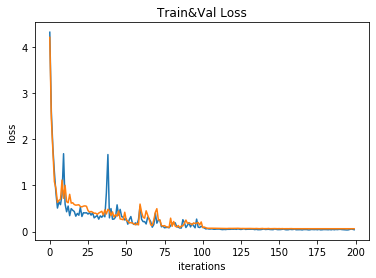

In [18]:
x = list(range(len(tlall)))
print(x)
plt.plot(x,tlall)
plt.plot(x,vlall)
plt.title('Train&Val Loss')
plt.xlabel('iterations')
plt.ylabel('loss')
 
plt.show()


## 单张图片测试

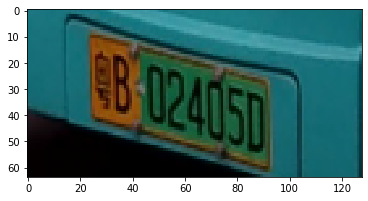

In [19]:
img1 = io.imread("./PlateKeyPoint/val/20171110083856993_粤B02405D_sp.jpg")

img1 = transform.resize(img1, (64, 128))
plt.imshow(img1)

In [20]:
img = img1.transpose((2, 0, 1))

In [21]:
img = np.array(img)
img = torch.from_numpy(img)
img = img.unsqueeze(0)
img = img.type(torch.FloatTensor)
img = img.cuda()

In [23]:
predict = net(img)

In [24]:
predict = predict.squeeze(2)
predict = predict.squeeze(0)

In [26]:
pkp = predict.cpu().detach().numpy()

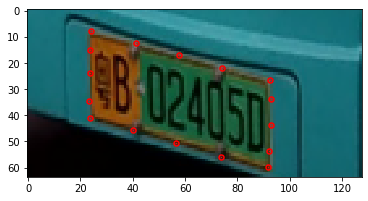

In [27]:
plt.imshow(img1)
plt.scatter(pkp[:, 0], pkp[:, 1], s=10, marker='.', c='r',linewidths = 5) 

## 验证集批量测试

0 torch.Size([3, 64, 128]) torch.Size([16, 2])
torch.Size([3, 64, 128])
1 torch.Size([3, 64, 128]) torch.Size([16, 2])
torch.Size([3, 64, 128])
2 torch.Size([3, 64, 128]) torch.Size([16, 2])
torch.Size([3, 64, 128])
3 torch.Size([3, 64, 128]) torch.Size([16, 2])
torch.Size([3, 64, 128])
4 torch.Size([3, 64, 128]) torch.Size([16, 2])
torch.Size([3, 64, 128])


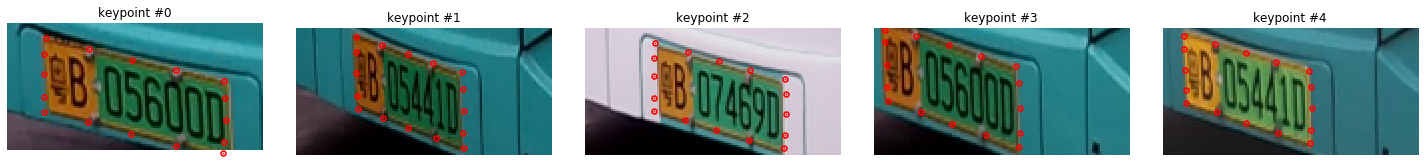

In [53]:
fig = plt.figure(figsize=(20,100))
for i in range(len(platekpval)):
    sample = platekpval[i]
    print(i, sample[0].shape, sample[1].shape )
    predict = net(sample[0].unsqueeze(0).cuda())
    predict = predict.squeeze(2)
    predict = predict.squeeze(0)
    pkp = predict.cpu().detach().numpy()
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title('keypoint #{}'.format(i))
    ax.axis('off')
    print(sample[0].size())
    plt.imshow(sample[0].cpu().numpy().transpose((1, 2, 0)))
    plt.scatter(pkp[:, 0], pkp[:, 1], s=10, marker='.', c='r',linewidths = 5) 
#     print(*sample.values())

    if i == 4:
        plt.show()
        break